# Topic Modeling
In order to cluster our documents, we used the unsupervised topic modeling technique of LDA. With topic modeling we hope to discover the categories that the topics are clustered into and use this structure to summarize/organize the documents.

# LDA (Latent Dirichlet Allocation)
 It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. This model was chosen due to the following advantages of LDA over its common counter part, non-negative matrix factorization.
1. Assumes each document has multiple topics.
2. Works best with longer texts such as full articles, essays, and books.
3. Evolves as you process new documents with the same model.
4. Results are not deterministic, meaning you might get different results each time for the same data set.

In particular, on the world bank's webpage, we have that there are 11 categories of loans. Some loans are wide ranging social programs that can have effects in more than one of these categories. LDA will be better to capture this multi-topic property of the loans. Additionally, the project descriptions (580 words on average) can be relatively long compared to say a tweet (280 words on average), so LDA should handle it better. The non-deterministic nature of the algorithm

## Assumptions for LDA
The following assumptions are necessary in order for this algorithm to be used:
1. The semantic content of a document is composed by combining one or more terms from one or more topics.
2. Certain terms are ambiguous, belonging to more than one topic, with different probability. However, in a document, the accompanying presence of specific neighboring terms (which belong to only one topic) will disambiguate their usage.
3. Most documents will contain only a relatively small number of topics. In the collection, individual topics will occur with differing frequencies. That is, they have a probability distribution, so that a given document is more likely to contain some topics than others.
4. Within a topic, certain terms will be used much more frequently than others. In other words, the terms within a topic will also have their own probability distribution.


In [1]:
from itertools import *
import numpy as np
import pandas as pd
from collections import Counter
import re
import os
import sys

from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()  


import string
import nltk
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
words = set(nltk.corpus.words.words())
#!{sys.executable} -m pip install spacy
from stop_words import get_stop_words
import spacy
from gensim import corpora, models
from gensim.corpora import Dictionary
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import pyLDAvis
import pyLDAvis.gensim_models

[nltk_data] Downloading package stopwords to /home/kbari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kbari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Extract project descriptions from each document
Currently extracts 2941/3205 project descriptions (91%)

In [2]:
## Path to text files
path = "/home/kbari/git_repo/FinanceErdosProj/PyMuPdf_Text/"
path1 = "/home/kbari/git_repo/FinanceErdosProj/Tesseract_Text/"

## Load from txt from files to a dataframe; Other information to include possibly?

#pd.read_table(file,header=None,quotechar=None,quoting=3,error_bad_lines=False) for file in DIR]
def txt_to_df(path):
    ''' Put all txt files into single dataframe'''
    DIR = os.listdir(path)
    raw_df_lst = []
    for i in range(len(DIR)):
        with open(path+DIR[i],encoding = "ISO-8859-1") as f:
            lines = f.readlines()
            data = '\n'.join(map(str,lines))
            #print(DIR[i])
            p = proj_desc_preprocess(data)
            if p is not None:
                p = p.replace("\n","")
                l = len(p)
            else:
                l = 0
            try:
                c = proj_name_preprocess(data)
                n = int(len(c))
            except:
                c = None
                n = int(0)
            di= pd.DataFrame([data,p,c],index=['raw_text','proj_desc','proj_name'],columns=[DIR[i]]).T
            raw_df_lst.append(di)
    #print(len(raw_df_lst))
    df_raw = pd.concat(raw_df_lst)
    return df_raw

## Grab Project Description   
def proj_desc_preprocess(text):
    ''' Grab Project Description'''
    if len(re.findall('Project Description',text,re.IGNORECASE)) > 0:
        start = 'Project Description'
        end = 'SCHEDULE'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Description of the Project',text,re.IGNORECASE)) > 0:
        start = 'Description of the Project'
        end = 'SCHEDULE'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Program Actions',text,re.IGNORECASE)) > 0:
        start = 'Program Actions'
        end = 'Section II'
        try:
            return text.split(start)[1].split(end)[0]
        except:
            return None
    elif len(re.findall('Schedule 3',text,re.IGNORECASE)) > 0:
        start = 'SCHEDULE 3'
        #end = 'SCHEDULE 3'
        try:
            return text.split(start)[1]
        except:
            return None
    elif len(re.findall('Schedule III',text,re.IGNORECASE)) > 0:
        start = 'SCHEDULE III'
        #end = 'SCHEDULE 3'
        try:
            return text.split(start)[1]
        except:
            return None
    else:
        #print('CASE 4')
        return None
    
## Grab Project Name   
def proj_name_preprocess(text):
    start = 'agreement'
    start1 = 'number'
    end = 'between'
    end1 = 'among'
    t = text.lower().split(start)[1].split(end)[0].strip()
    s = text.lower().split(start1)[1].split(end)[0].strip()
    r = text.lower().split(start)[1].split(end1)[0].strip()
    if 'date' in t:
        if 'date' in s:
            if 'date' in r:
                return None
            else:
                return r
        else:
            return s
    else:
        return t



df = txt_to_df(path)
df1 = txt_to_df(path1)
dF = pd.concat([df,df1])
dF.fillna('',inplace=True)
dF['corp'] = dF[['proj_name', 'proj_desc']].agg(' '.join, axis=1)
## Drop null proj desc/proj_name
dG = dF[dF['corp'].map(len)!=0]
dG.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3205 entries, 2006_july_4_213051468296429321_loan-agreement-l4825-ro-conformed.txt to 2019_april_2_393831555439741186_official-documents-loan-agreement-for-loan-8932-ph-closing-package.txt
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   raw_text   3205 non-null   object
 1   proj_desc  3205 non-null   object
 2   proj_name  3205 non-null   object
 3   corp       3205 non-null   object
dtypes: object(4)
memory usage: 125.2+ KB


### Explore project description lengths and common words

In [3]:
document_lengths = np.array(list(map(len, dG.corp.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 538.5753510140405.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 6604.


/home/kbari/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


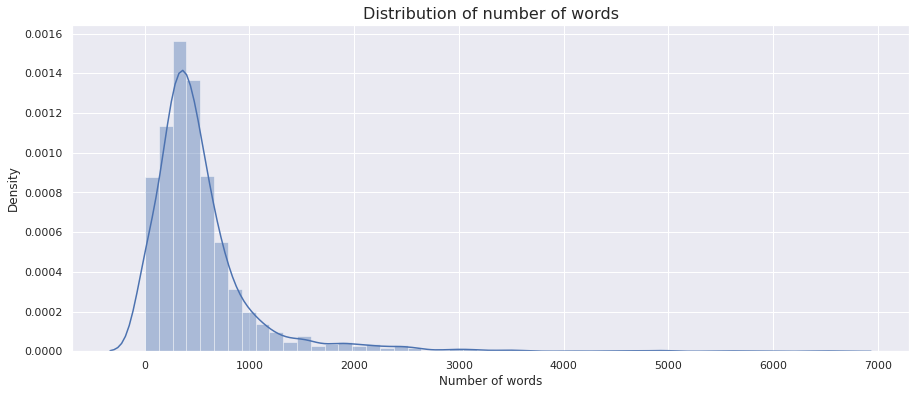

In [4]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

### Function to tokenize texts in monograms. Additionally removes punctuation, numeric terms, non-english terms, non-english characters then lemmatizes.

In [5]:
W = ['project','amount','amortization','due','and','account','achieve','assistance','respect','strengthen','strengthening','improve','inter','selected','new','thereof','withdrawal','withdrawn','subject','plan','taken','least','schedule','carrying','following','agree','upon','said','part','made','paragraph','implementation','borrower','date','january','february','march','april','may','june','july','august','september','october','november','december','for','management','section','id','the','payment','objective','provision','bank','system','time','loan','development','shall','set','forth','agreement','general','down']

#'project','policy','equipment','principal','technical','capacity','training','assistance','support','program','sector','improvement','amount',
def text_preprocess(text):
    '''
    Remove all punctuation,stopwords, non-english words, numbers, lemmatize -> returns list of words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc =  [word for word in nopunc.split() if word.isalnum()]
    nopunc =  [word.lower() for word in nopunc if word not in stopwords.words('english')]
    nopunc =  [word for word in nopunc if len(word)>2]
    nopunc = [word for word in nopunc if word not in W]
    nopunc = [w for w in nopunc if w.lower() in words or not w.isalpha()]
    return [stemmer.lemmatize(word) for word in nopunc]

In [6]:
# stop_words = stopwords.words('english')
# data1 = dG.corp.values.tolist()

# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
              
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# def make_bigrams(texts):
#     return [bigram_mod[doc] for doc in texts]

# def make_trigrams(texts):
#     return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent)) 
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out
              
# data_words = list(sent_to_words(data1))
# bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# data_words_nostops = remove_stopwords(data_words)
# data_words_bigrams = make_bigrams(data_words_nostops)
# # Initialize spacy 'en' model
# #!{sys.executable} -m python3 -m spacy download en
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
              
# print(data_lemmatized[0])

In [7]:
# # Create Dictionary
# id2word = corpora.Dictionary(data_lemmatized)

# # Create Corpus
# texts = data_lemmatized

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]

# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=11, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

# print(lda_model.print_topics())

# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

### Same function as above but for bigrams

In [8]:
def text_preprocess_2(text):
    '''
    Remove all punctuation,stopwords, non-english words, numbers, lemmatize -> returns list of words
    '''
    bigrm = nltk.bigrams(text_preprocess(text))
    B = ['_'.join(b) for b in bigrm]
    return B

# Build the bigram and trigram models
#bigram = gensim.models.Phrases(list(dictionary.values()), min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
#bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
#print(bigram_mod[data_words[0]])

In [9]:
docLabels= dG.index
data = dG.corp

### Example to see how processing performs

In [10]:
i = 0
#print(data[i])
#print(text_preprocess(data[i]))
#print(text_preprocess_2(data[i]))

### Add column of processed text as well as create bag of words for each

In [11]:
## Add column of processed texts
def lem_stem(df):
    df['stem'] = list(map(lambda sentence: text_preprocess(sentence),df.corp))
    return
    
def lem_stem2(df):
    df['stem'] = list(map(lambda sentence: text_preprocess_2(sentence),df.corp))
    return

In [12]:
%%time
## lem_stem for words or lem_stem2 for bigrams
lem_stem2(dG)

CPU times: user 1min 57s, sys: 10.1 s, total: 2min 7s
Wall time: 2min 7s


### Word frequency

/home/kbari/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


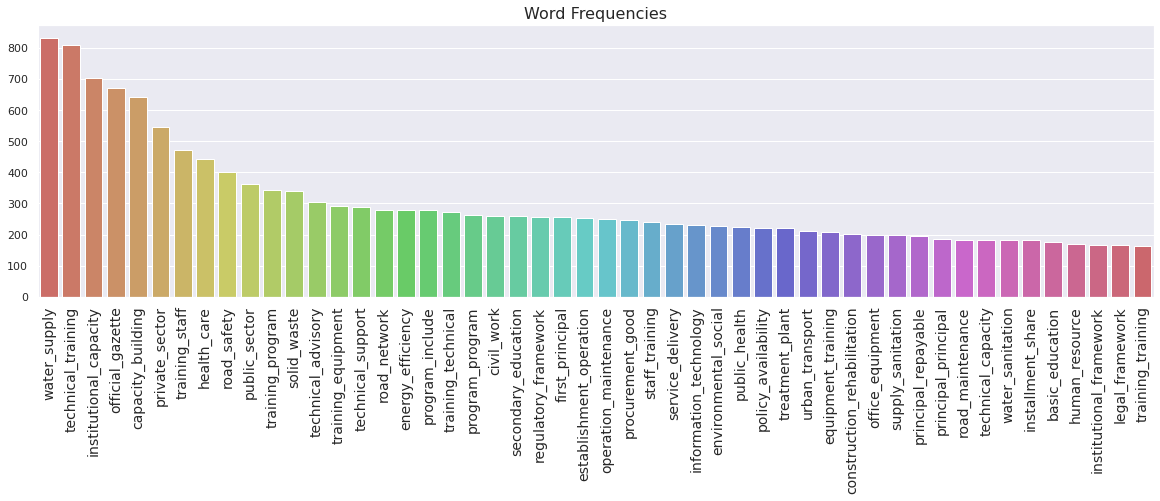

In [13]:
token_dict = Counter(np.concatenate(dG.stem.values))

token_df = pd.DataFrame.from_dict(token_dict, orient='index')
token_df.rename(columns={0: 'count'}, inplace=True)
token_df.sort_values('count', ascending=False, inplace=True)

def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(token_df)
ax.set_title("Word Frequencies", fontsize=16);

In [14]:
dictionary = Dictionary(documents=dG.stem.values)

print("Found {} words.".format(len(dictionary.values())))

Found 174853 words.


In [15]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify() 
print("Left with {} words.".format(len(dictionary.values())))

Left with 26526 words.


### Create column for bag of words to run LDA

In [16]:
# Bag of Words for each lemmatized document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stem))
    
document_to_bow(dG)
corpus = dG.bow

## Hyperparameter tuning

In [17]:
# Hyperparameter Tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=4000,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=dG.stem.values.tolist(), dictionary=dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [18]:
# #import tqdm

# min_topics = 5
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
# model_results = {'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# for k in topics_range:
#     for a in alpha:
#         for b in beta:
#             #print(k,a,b)
#             cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, 
#                                           k=k, a=a, b=b)
#             #print(cv)
#             model_results['Topics'].append(k)
#             model_results['Alpha'].append(a)
#             model_results['Beta'].append(b)
#             model_results['Coherence'].append(cv)

# #dr = pd.DataFrame(model_results)


## Run LDA Model on all documents

In [19]:
corpus = dG.bow
num_topics = 11
a = 'asymmetric'
#b = 

In [20]:
%%time
#LDA multicore approach
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        #workers=4,
                        chunksize=4000,
                        passes=10,
                        alpha=a)

CPU times: user 26.9 s, sys: 11.9 s, total: 38.8 s
Wall time: 38.8 s


In [21]:
LDAmodel.save('lda2.model')

In [22]:
LDAmodel.print_topics()

[(0,
  '0.006*"institutional_capacity" + 0.005*"water_supply" + 0.004*"capacity_building" + 0.004*"solid_waste" + 0.003*"technical_training" + 0.003*"secondary_education" + 0.003*"technical_advisory" + 0.003*"training_staff" + 0.002*"training_equipment" + 0.002*"staff_training"'),
 (1,
  '0.020*"water_supply" + 0.006*"supply_sanitation" + 0.004*"water_sanitation" + 0.004*"private_sector" + 0.004*"energy_efficiency" + 0.004*"treatment_plant" + 0.003*"capacity_building" + 0.003*"technical_training" + 0.003*"water_treatment" + 0.003*"institutional_capacity"'),
 (2,
  '0.013*"health_care" + 0.011*"official_gazette" + 0.005*"technical_training" + 0.005*"primary_health" + 0.004*"health_sector" + 0.004*"public_health" + 0.004*"health_insurance" + 0.003*"public_sector" + 0.003*"secondary_education" + 0.003*"program_include"'),
 (3,
  '0.014*"official_gazette" + 0.008*"program_include" + 0.007*"policy_availability" + 0.004*"under_program" + 0.004*"social_protection" + 0.004*"availability_procee

In [23]:
# Compute Perplexity
print('\nPerplexity: ', LDAmodel.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=LDAmodel, texts=dG.stem.values.tolist(), dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.33030380503302

Coherence Score:  0.4499270839691818


## Visualize output of model
Adjusting lambda to values close to 0 highlights potentially rare but more exclusive terms for the selected topic. Larger lambda values (closer to 1) highlight more frequently occurring terms in the document that might not be exclusive to the topic. 
http://www.kennyshirley.com/LDAvis/

In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LDAmodel, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda2.html')
vis

/home/kbari/.local/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.118541 -0.030585       1        1  18.405026
9     -0.263302  0.258710       2        1  11.709566
2      0.033570  0.023995       3        1  10.147738
1      0.077905 -0.006399       4        1   9.953906
5      0.072719 -0.008970       5        1   9.281147
4     -0.324198 -0.235945       6        1   9.280761
8      0.094960 -0.025968       7        1   8.781441
3      0.011604  0.076767       8        1   6.463599
6      0.076724 -0.013774       9        1   6.434335
7      0.043001 -0.028511      10        1   5.372740
10     0.058476 -0.009319      11        1   4.169740, topic_info=                   Term        Freq       Total Category  logprob  loglift
467        water_supply  764.000000  764.000000  Default  30.0000  30.0000
249    official_gazette  611.000000  611.000000  Default  29.0000  29.0000
1640        road_safety  362.000000  362.000000  Default  28.0000  28.0000
785         health_care  411.000000  411.000000  Default  27.0000  27.0000
4662    first_principal  233.000000  233.000000  Default  26.0000  26.0000
...                 ...         ...         ...      ...      ...      ...
365          civil_work   13.077255  235.272874  Topic11  -6.6453   0.2874
572      private_sector   13.843794  492.208511  Topic11  -6.5884  -0.3937
195   technical_support   12.898428  262.724451  Topic11  -6.6591   0.1633
473   social_protection   11.857585  129.079034  Topic11  -6.7433   0.7899
467        water_supply   12.180683  764.806071  Topic11  -6.7164  -0.9625

[812 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
475        1  0.113949  access_information
475        3  0.151932  access_information
475        5  0.037983  access_information
475        7  0.151932  access_information
475        8  0.037983  access_information
...      ...       ...                 ...
26019     11  0.930191          would_sell
7720       2  0.336754           year_year
7720       4  0.630055           year_year
7720       6  0.021726           year_year
7720       7  0.010863           year_year

[2268 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 3, 2, 6, 5, 9, 4, 7, 8, 11])

## Topics in Diagram (Parenthetical number is topics from LDA model)
1.  
2. 
3. 
4. 
5. 
6. 
7. 
8. 
9. 
10. 
11. 

## Topics from World Bank
Agriculture

Education

Energy & Extractives

Financial Sector

Health

Industry, Trade and Services

Info and Communication

Public Admin

Social Protection

Transportation

Water/Sanit/Waste

## Predict Topics for Document

In [30]:
def lda_predict(doc,model):
    ''' Displays distribution of topics within corpus document'''
    s = text_preprocess_2(doc)
    b = list(dictionary.doc2bow(s))
    p = list(model[b])
    topics = sorted(p,key=lambda x:x[1],reverse=True)
    return topics

i = 5
print(data[i])
p = lda_predict(data[i],LDAmodel)[0][0]
print(text_preprocess(data[i]))
print(p)

(early childhood development project) The objective of the Project is to support the Borrowerâs Ten-year National Early Chilassist the Borrower in implementing its Ten-Year National Early Childhood Development Program in Regions VI, VII and XII of the Philippines (the Project Regions), in order to ensure the survival and promote the physical and mental development of young children in the most vulnerable and disadvantaged segments of the population in such Project Regions.The Project consists of the following parts, subject to such modifications thereof as the Borrower and the Bank may agree upon from time to time to achieve such objectives:Part A:  Early Childhood Development Services Delivery1.Support for the delivery of the following programs in the Project RegionsImplementation of programs to improve the delivery of services for early childhood development in the Project Regions, consisting of:(a)Expanded Program of Ian expanded program of immunization, through the provision of e

## Add Sector Information

In [31]:
def add_sector(df):
    df['sector'] = [lda_predict(f,LDAmodel)[0][0] for f in df.corp]

In [32]:
add_sector(dG)

In [33]:
dG.sector.head()

2006_july_4_213051468296429321_loan-agreement-l4825-ro-conformed.txt                                                10
1996_december_13_893741468282540693_conformed-copy--l4113--public-finance-management-project--loan-agreement.txt     7
1994_september_30_745841468259144739_conformed-copy--l3792--land-administration-project--loan-agreement.txt         10
1990_june_22_418341468249703395_conformed-copy--l3188--housing-project--loan-agreement.txt                           0
2009_june_11_345301468026058559_loan-agreement-l7686-cr-conformed.txt                                                2
Name: sector, dtype: int64

In [34]:
num_0 = len(dG[dG['sector'] == 0])
num_1 = len(dG[dG['sector'] == 1])
num_2 = len(dG[dG['sector'] == 2])
num_3 = len(dG[dG['sector'] == 3])
num_4 = len(dG[dG['sector'] == 4])
num_5 = len(dG[dG['sector'] == 5])
num_6 = len(dG[dG['sector'] == 6])
num_7 = len(dG[dG['sector'] == 7])
num_8 = len(dG[dG['sector'] == 8])
num_9 = len(dG[dG['sector'] == 9])
num_10 = len(dG[dG['sector'] == 10])
#num_10 = len(dG[dG['sector'] == 10])
print(num_0,num_1,num_2,num_3,num_4,num_5,num_6,num_7,num_8,num_9,num_10)

836 401 361 246 118 296 219 172 314 120 122


In [ ]:
# tokenized_only_dict = Counter(np.concatenate(dG.tokenized_text.values))

# tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
# tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

# tokenized_only_df.sort_values('count', ascending=False, inplace=True)

# dictionary = Dictionary(documents=dG.stemmed_text.values)

# cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
# cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

# cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
# del cleansed_words_df['id']

# cleansed_words_df.sort_values('count', ascending=False, inplace=True)

# fig, ax = plt.subplots(figsize=(15,6))

# ax.set_title("Distribution of number of words", fontsize=16)
# ax.set_xlabel("Number of words")
# sns.distplot(document_lengths, bins=50, ax=ax);

# def get_good_tokens(sentence):
#     replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
#     removed_punctation = list(filter(lambda token: token, replaced_punctation))
#     return removed_punctation

# def lda_get_good_tokens(df):
#     df['text'] = df.proj_desc.str.lower()
#     df['tokenized_text'] = list(map(nltk.word_tokenize, df.proj_desc))
#     df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

# lda_get_good_tokens(dG)

# tokenized_only_dict = Counter(np.concatenate(dG.stem.values))

# tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
# tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

# tokenized_only_df.sort_values('count', ascending=False, inplace=True)

# # I made a function out of this since I will use it again later on 
# def word_frequency_barplot(df, nr_top_words=50):
#     """ df should have a column named count.
#     """
#     fig, ax = plt.subplots(1,1,figsize=(20,5))

#     sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

#     ax.set_xticks(list(range(nr_top_words)))
#     ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
#     return ax
    
# ax = word_frequency_barplot(tokenized_only_df)
# ax.set_title("Word Frequencies", fontsize=16);

# def remove_stopwords(df):
#     """ Removes stopwords based on a known set of stopwords
#     available in the nltk package. In addition, we include our
#     made up word in here.
#     """
#     # Luckily nltk already has a set of stopwords that we can remove from the texts.
#     stopwords = nltk.corpus.stopwords.words('english')
#     # we'll add our own special word in here 'qwerty'
#     stopwords.append('the')

#     df['stopwords_removed'] = list(map(lambda doc:
#                                        [word for word in doc if word not in stopwords],
#                                        df['tokenized_text']))

# remove_stopwords(dG)


# def stem_words(df):
#     lemm = nltk.stem.WordNetLemmatizer()
#     df['lemmatized_text'] = list(map(lambda sentence:
#                                      list(map(lemm.lemmatize, sentence)),
#                                      df.stopwords_removed))

#     p_stemmer = nltk.stem.porter.PorterStemmer()
#     df['stemmed_text'] = list(map(lambda sentence:
#                                   list(map(p_stemmer.stem, sentence)),
#                                   df.lemmatized_text))

# stem_words(dG)

# dictionary = Dictionary(documents=dG.stemmed_text.values)

# print("Found {} words.".format(len(dictionary.values())))

# dictionary.filter_extremes(no_above=0.8, no_below=3)

# dictionary.compactify()  # Reindexes the remaining words after filtering
# print("Left with {} words.".format(len(dictionary.values())))

# #Make a BOW for every document
# def document_to_bow(df):
#     df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
# document_to_bow(dG)

# # we make a function such that later on when we make the submission, we don't need to write duplicate code
# def lda_preprocessing(df):
#     """ All the preprocessing steps for LDA are combined in this function.
#     All mutations are done on the dataframe itself. So this function returns
#     nothing.
#     """
#     lda_get_good_tokens(df)
#     remove_stopwords(df)
#     stem_words(df)
#     document_to_bow(df)

# cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
# cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

# cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
# del cleansed_words_df['id']

# cleansed_words_df.sort_values('count', ascending=False, inplace=True)

#ax = word_frequency_barplot(cleansed_words_df)
#ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

#def stem_words(df):
#    lemm = nltk.stem.WordNetLemmatizer()
#    df['lemmatized_text'] = list(map(lambda sentence:
#                                     list(map(lemm.lemmatize, sentence)),
#                                     df.stopwords_removed))
#
#    p_stemmer = nltk.stem.porter.PorterStemmer()
#    df['stemmed_text'] = list(map(lambda sentence:
#                                  list(map(p_stemmer.stem, sentence)),
#                                  df.lemmatized_text))

#tokenizer = RegexpTokenizer(r'\w+')
#en_stop = get_stop_words('en')
#p_stemmer = PorterStemmer()

#def text_preprocess(text):
#    tokens = tokenizer.tokenize(text.lower())
#    t = [i for i in tokens if not i in en_stop]	
#    t1 = [p_stemmer.stem(i) for i in t]
#    return t1


### Removes punctuation, stopwords, lemmatizes
#def text_preprocess(text):
#    '''
#    Remove all punctuation,stopwords, lemmatize -> returns list of words
#    '''
#    stemmer = WordNetLemmatizer()
#    nopunc = [char for char in text if char not in string.punctuation]
#    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
#    nopunc =  [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
#    nopunc = [w for w in nopunc if w.lower() in words or not w.isalpha()]
#    return [stemmer.lemmatize(word) for word in nopunc]

#T = [ text_preprocess(t) for t in dG.proj_desc]